### Cài đặt các thư viện cần thiết trong quá trình thực thi
- Để thực hiện được các yêu cầu, chúng ta cần đảm bảo rằng các thư viện cần thiết đã được cài đặt trong môi trường Python. Các thư viện này bao gồm:
  - `pandas`: Thư viện này được sử dụng để xử lý và phân tích dữ liệu.
  - `graphviz`: Thư viện này được sử dụng để tạo đồ thị và biểu đồ từ dữ liệu.
  - `matplotlib`: Thư viện này được sử dụng để vẽ đồ thị và biểu đồ.
  - `sklearn`: Thư viện này được sử dụng để xây dựng và đánh giá mô hình Decision Tree.
  - `seaborn`: Thư viện này được sử dụng để tạo các biểu đồ thống kê và trực quan hóa dữ liệu. 
  - `tabulate`: Thư viện này được sử dụng để tạo bảng dữ liệu đẹp và dễ đọc.

- Ngoài ra, với việc sử dụng graphviz, thư viện này cần được cài đặt trên hệ thống máy thực thi. Mã nguồn đã tích hợp để có thể chạy trực tiếp mà không cần phải cài đặt thêm bằng cách thiết lập lại biến môi trường PATH trong Python, nhằm giúp chương trình tìm được thư viện thực thi (binary) của Graphviz khi chạy.

In [15]:
%pip install pandas matplotlib scikit-learn graphviz pydotplus tabulate ipython seaborn pydot

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import graphviz
from IPython.display import display, Markdown
import seaborn as sns
from tabulate import tabulate

import os
project_dir = os.getcwd()
graphviz_bin_path = os.path.join(project_dir, "bin")
os.environ["PATH"] += os.pathsep + graphviz_bin_path

### Đọc dữ liệu từ file CSV
- Với đường dẫn đến file CSV là `data/NHANES_age_prediction.csv`, chúng ta sẽ sử dụng thư viện pandas để đọc dữ liệu từ file này.
- Loại bỏ các cột không cần thiết trong quá trình phân tích dữ liệu như tuổi của người tham gia (ảnh hưởng lớn đến việc xếp nhóm tuổi, gây mất cân bằng), số thứ tự (yếu tố khách quan không ảnh hưởng).
- Tạo tập dữ liệu feature và target từ dữ liệu đã đọc được.
- Cuối cùng, hiển thị các thông tin về tập dữ liệu.

In [17]:
file_path = 'data/NHANES_age_prediction.csv'
data = pd.read_csv(file_path, sep=',')

features = data.drop('age_group', axis=1)
features = features.drop('SEQN', axis=1)
features = features.drop('RIDAGEYR', axis=1)
labels = data['age_group']

display(Markdown(f"### 🔍 Dataset Infomation:"))
print(f"Number of samples: {len(data)}\nNumber of features: {len(features.columns)}")
print()
display(Markdown(f"###  📊 Age distribution:"))
print(labels.value_counts())

### 🔍 Dataset Infomation:

Number of samples: 2278
Number of features: 7



###  📊 Age distribution:

age_group
Adult     1914
Senior     364
Name: count, dtype: int64


### Hàm phân chia dữ liệu
- Với đầu vào vào là tập dữ liệu và tỷ lệ chia, hàm này sẽ phân chia dữ liệu thành 2 phần: tập huấn luyện và tập kiểm tra tương ứng với tỷ lệ đã cho.
- Việc chia dữ liệu luôn đảm bảo rằng dữ liệu đã được trộn ngẫu nhiên trước khi chia, nhằm đảm bảo tính ngẫu nhiên và không có xảy ra việc tỷ lệ các loại không đều so với tập dữ liệu ban đầu.

In [18]:
def create_stratified_splits(features, labels, test_sizes):
    splits = {}
    for test_size in test_sizes:
        feature_train, feature_test, label_train, label_test = train_test_split(
            features, labels, 
            test_size=test_size, 
            random_state=42,
            stratify=labels
        )
        split_name = f"train_{100-int(test_size*100)}_test_{int(test_size*100)}"
        splits[split_name] = {
            'feature_train': feature_train,
            'label_train': label_train,
            'feature_test': feature_test,
            'label_test': label_test
        }
    return splits

test_sizes = [0.6, 0.4, 0.2, 0.1]
splits = create_stratified_splits(features, labels, test_sizes)

### Trực quan hóa các tập dữ liệu
- Với việc có được các tập dữ liệu đã phân chia, chúng ta sử dụng matplotlib.pyplot để trực quan hóa các tập dữ liệu này.
- Việc thấy được sự phân bố của các loại trong tập dữ liệu sẽ giúp chúng ta có cái nhìn tổng quan về dữ liệu và cách mà các loại được phân chia trong tập dữ liệu.

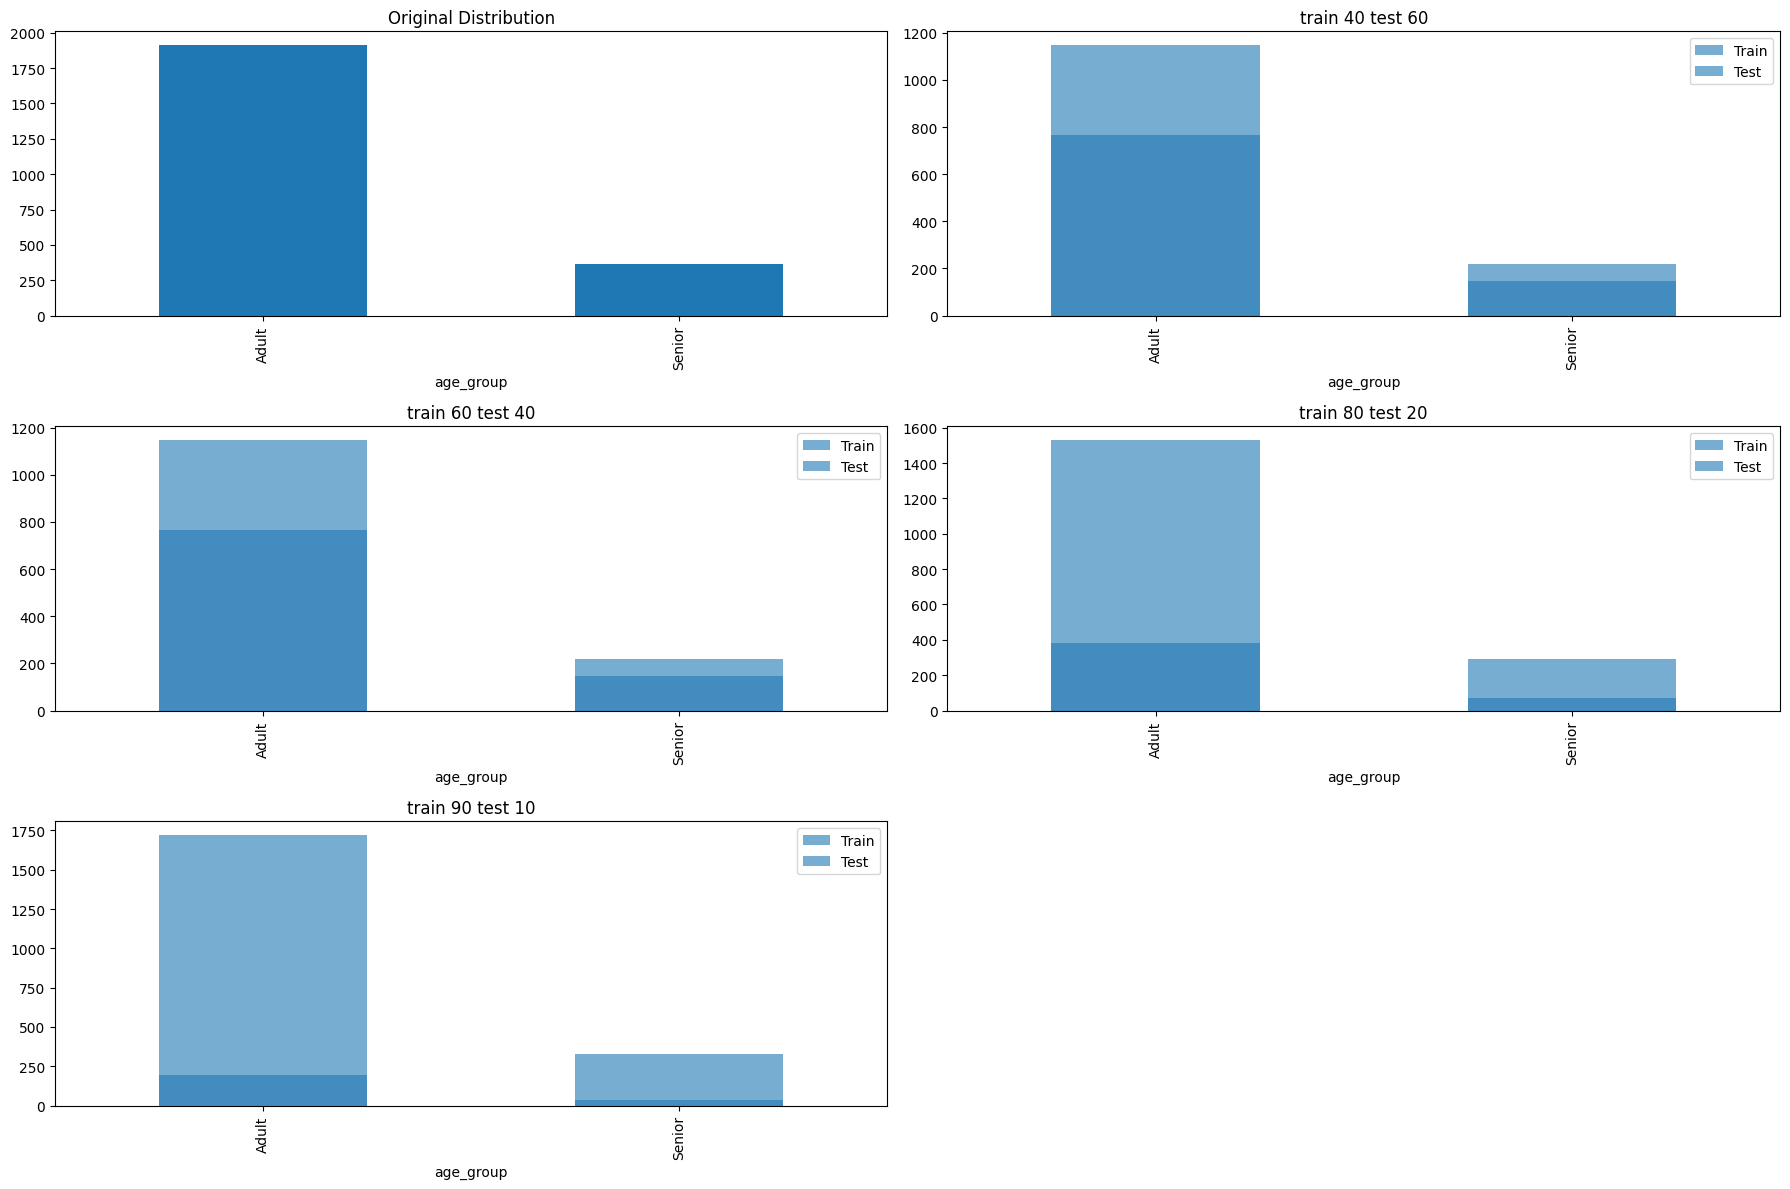

In [19]:
plt.figure(figsize=(18, 12))
plt.subplot(3, 2, 1)
labels.value_counts().plot(kind='bar')
plt.title('Original Distribution')

for i, (name, data) in enumerate(splits.items(), 2):
    plt.subplot(3, 2, i)
    data['label_train'].value_counts().plot(kind='bar', alpha=0.6, label='Train')
    data['label_test'].value_counts().plot(kind='bar', alpha=0.6, label='Test')
    plt.title(name.replace('_', ' '))
    plt.legend()

plt.tight_layout()
plt.show()

### Xây dựng mô hình Decision Tree
- Với việc sử dụng thư viện sklearn, chúng ta sẽ xây dựng mô hình Decision Tree với tiêu chí đánh giá dựa trên Information Gain và các thông số mặc định.
- Sau đó, sử dụng thư viện graphviz để trực quan hóa mô hình Decision Tree đã xây dựng.
- Cuối cùng, chúng ta sẽ sử dụng tập kiểm tra để đánh giá độ chính xác của mô hình. Các thông số sẽ được trực quan hóa bằng classification_report và confusion_matrix từ sklearn và seaborn.

### 🌳 Decision Tree Visualization

--------------------------------------------------


#### Splitting dataset with train 40 test 60

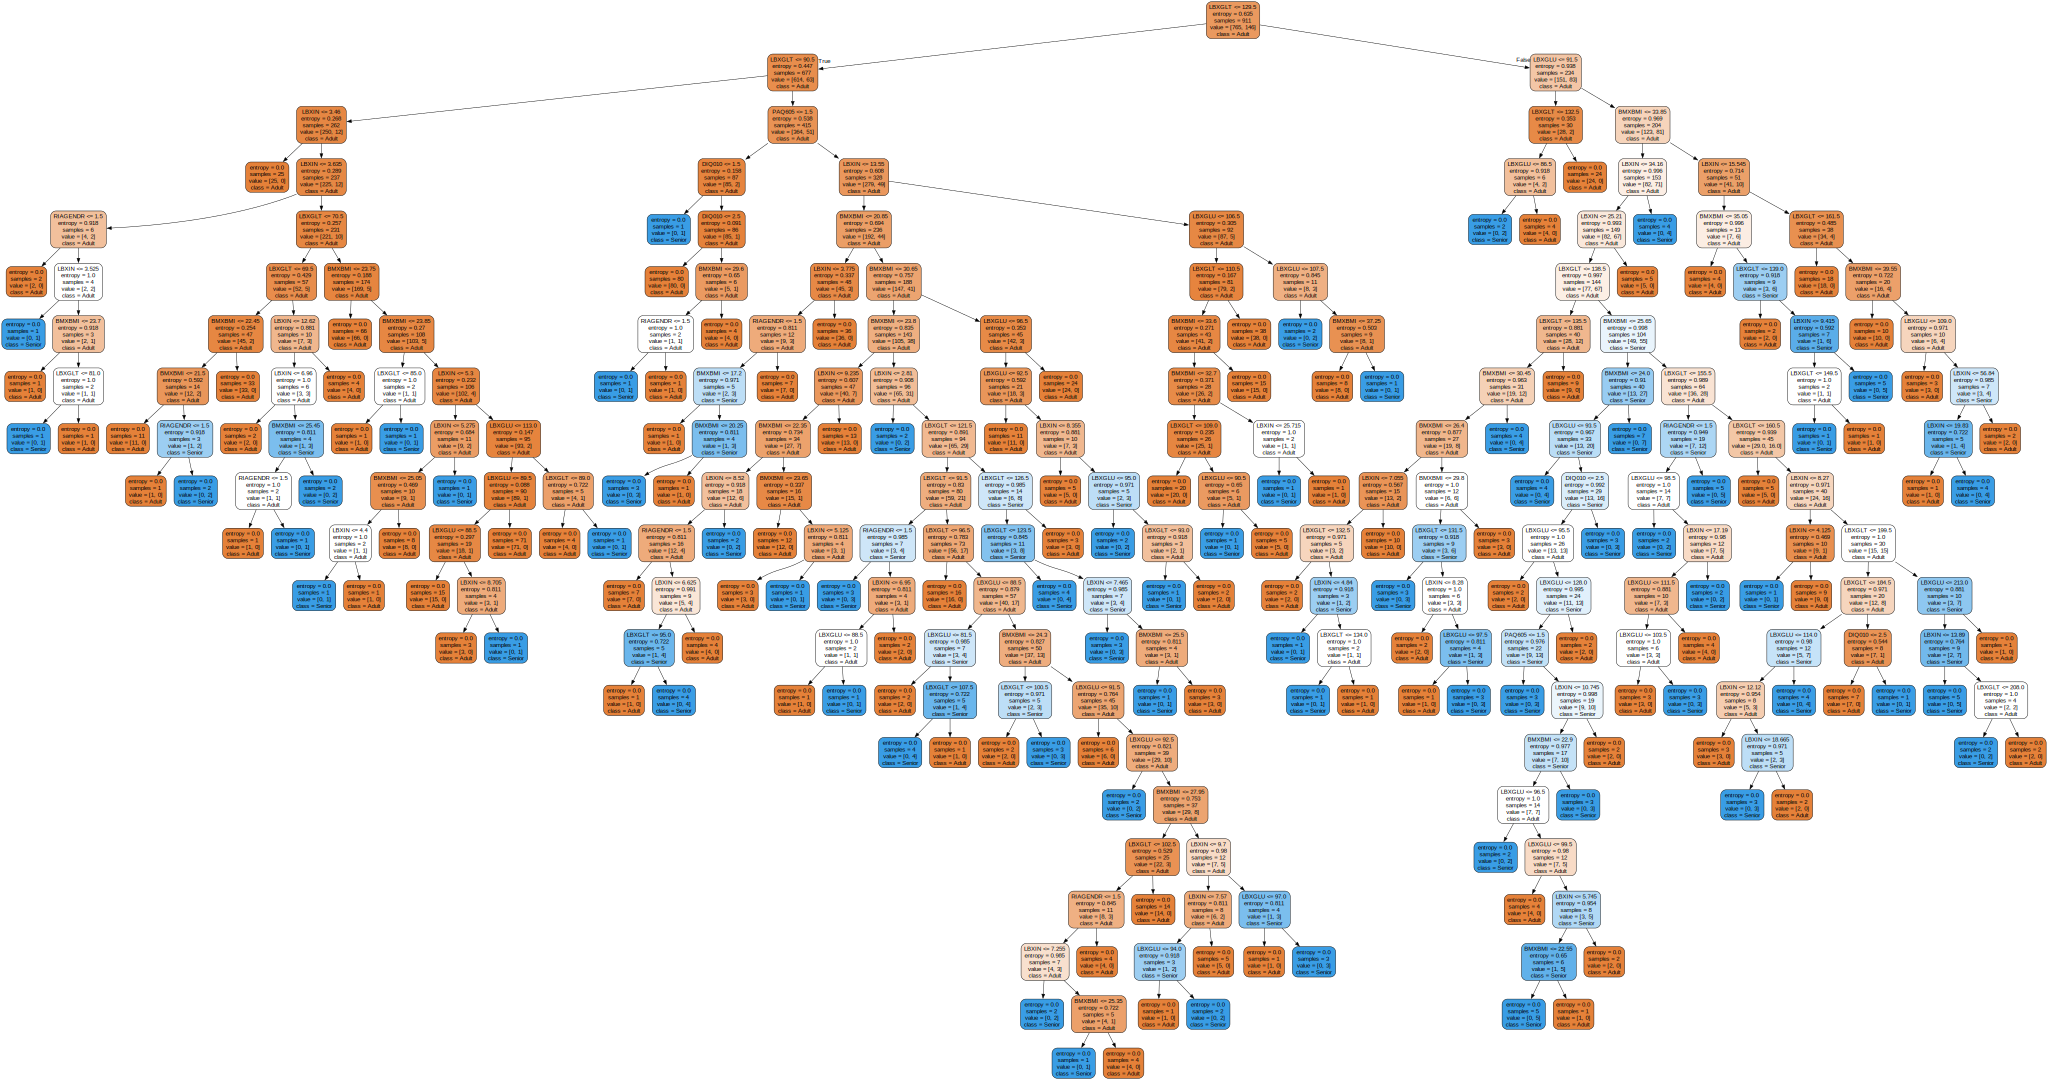

### 📋 Classification Report

              precision    recall  f1-score   support

       Adult       0.87      0.85      0.86      1149
      Senior       0.31      0.36      0.33       218

    accuracy                           0.77      1367
   macro avg       0.59      0.60      0.60      1367
weighted avg       0.78      0.77      0.78      1367

Accuracy: 0.77


### 📊 Confusion Matrix

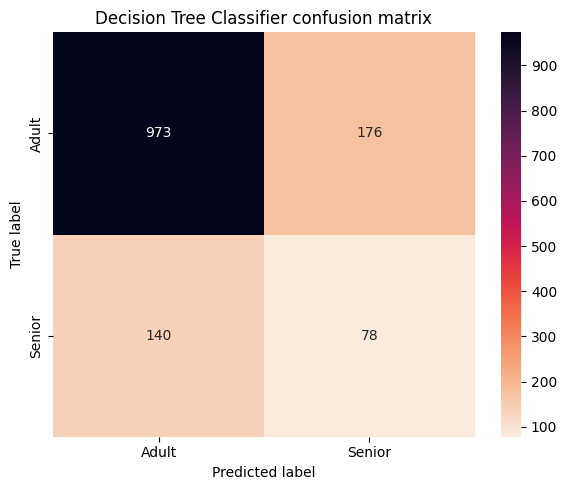

--------------------------------------------------


#### Splitting dataset with train 60 test 40

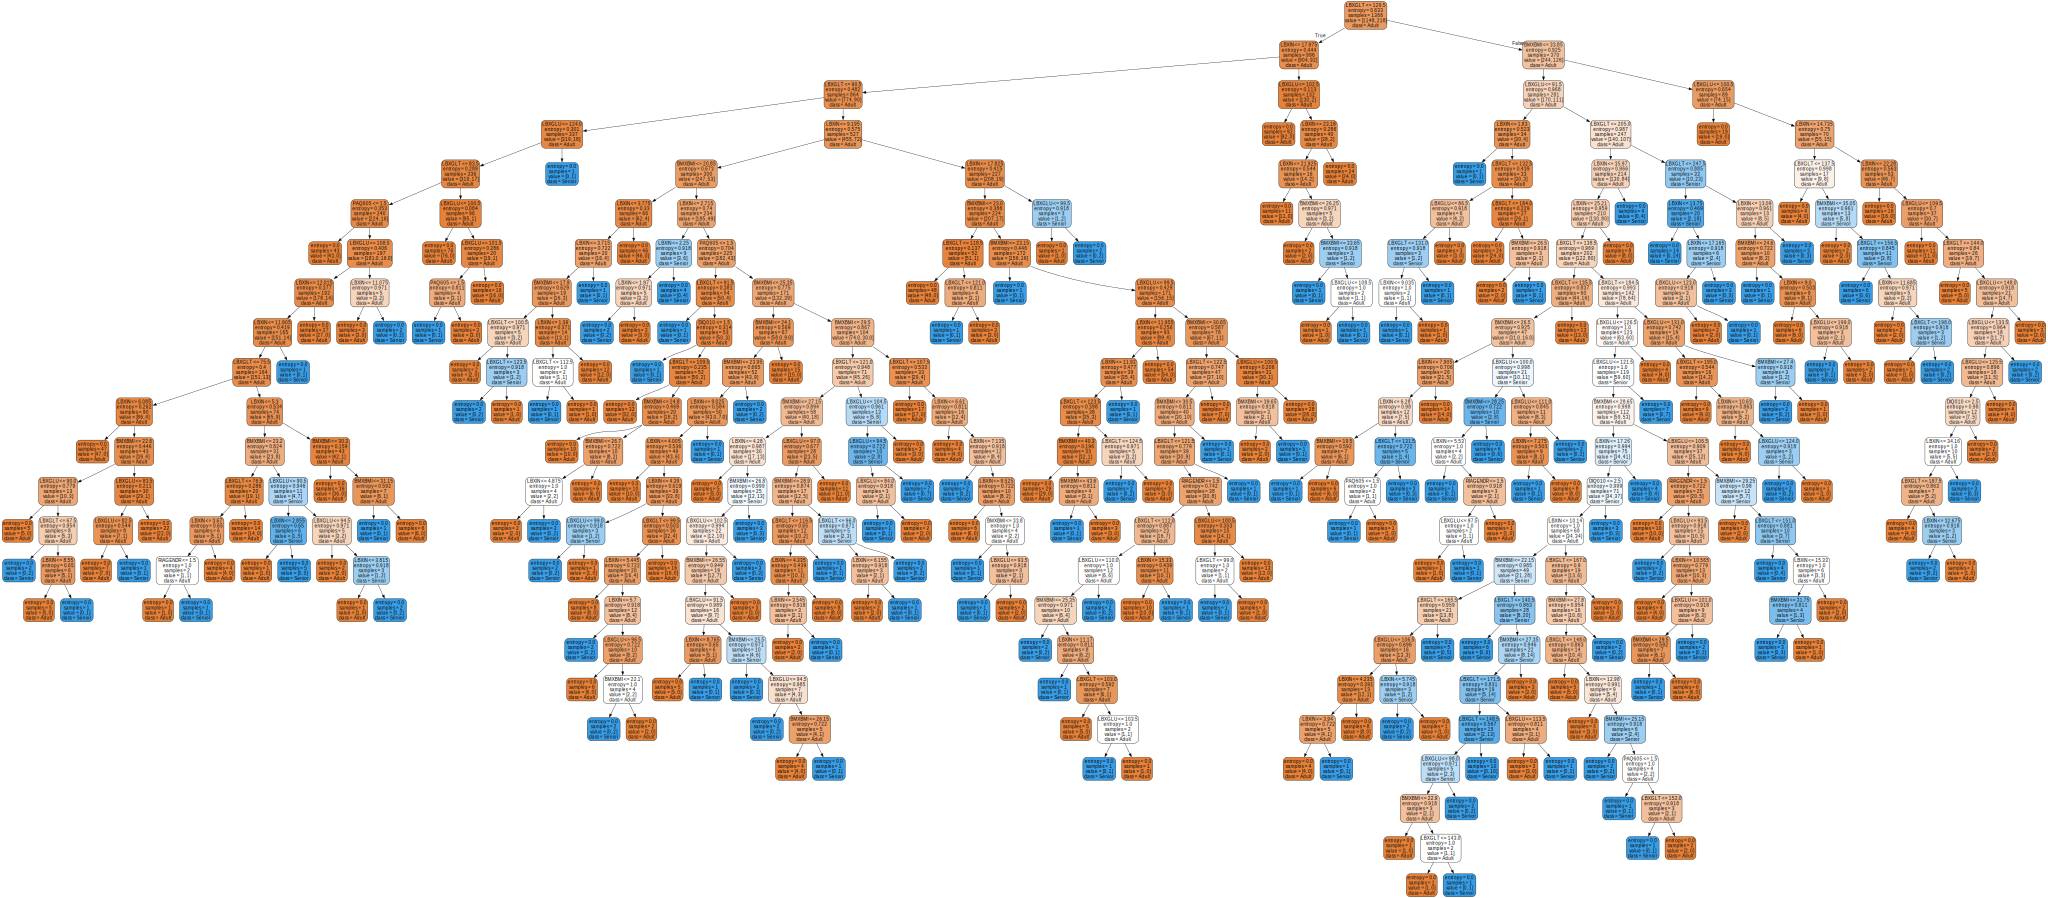

### 📋 Classification Report

              precision    recall  f1-score   support

       Adult       0.86      0.87      0.87       766
      Senior       0.29      0.27      0.28       146

    accuracy                           0.78       912
   macro avg       0.57      0.57      0.57       912
weighted avg       0.77      0.78      0.77       912

Accuracy: 0.78


### 📊 Confusion Matrix

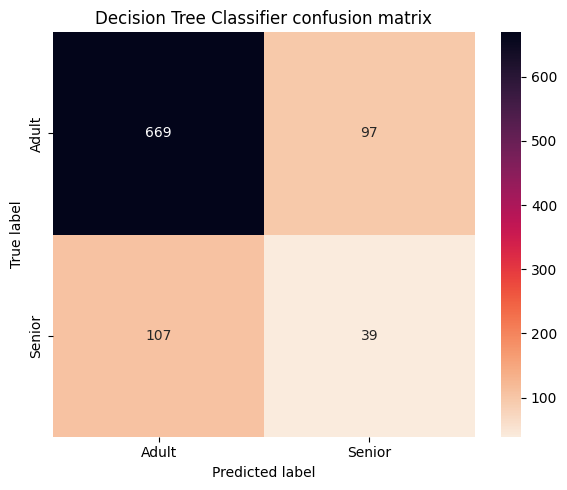

--------------------------------------------------


#### Splitting dataset with train 80 test 20

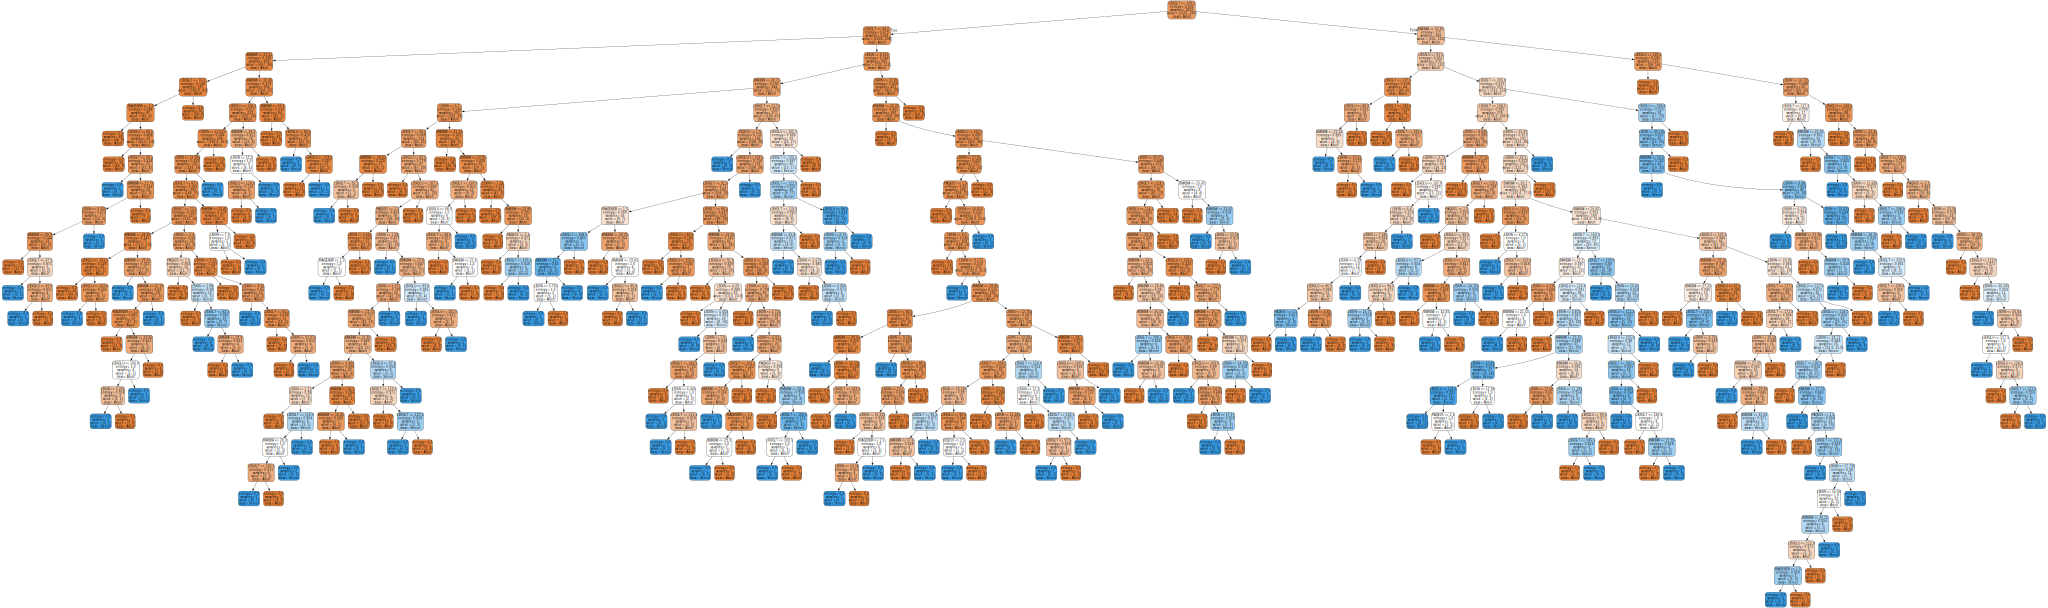

### 📋 Classification Report

              precision    recall  f1-score   support

       Adult       0.86      0.85      0.85       383
      Senior       0.24      0.25      0.24        73

    accuracy                           0.76       456
   macro avg       0.55      0.55      0.55       456
weighted avg       0.76      0.76      0.76       456

Accuracy: 0.76


### 📊 Confusion Matrix

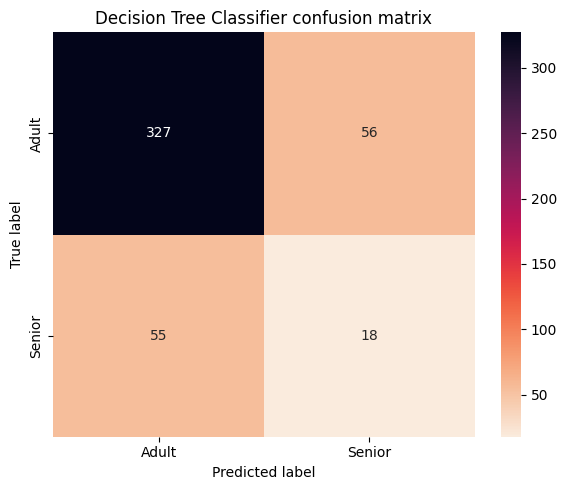

--------------------------------------------------


#### Splitting dataset with train 90 test 10

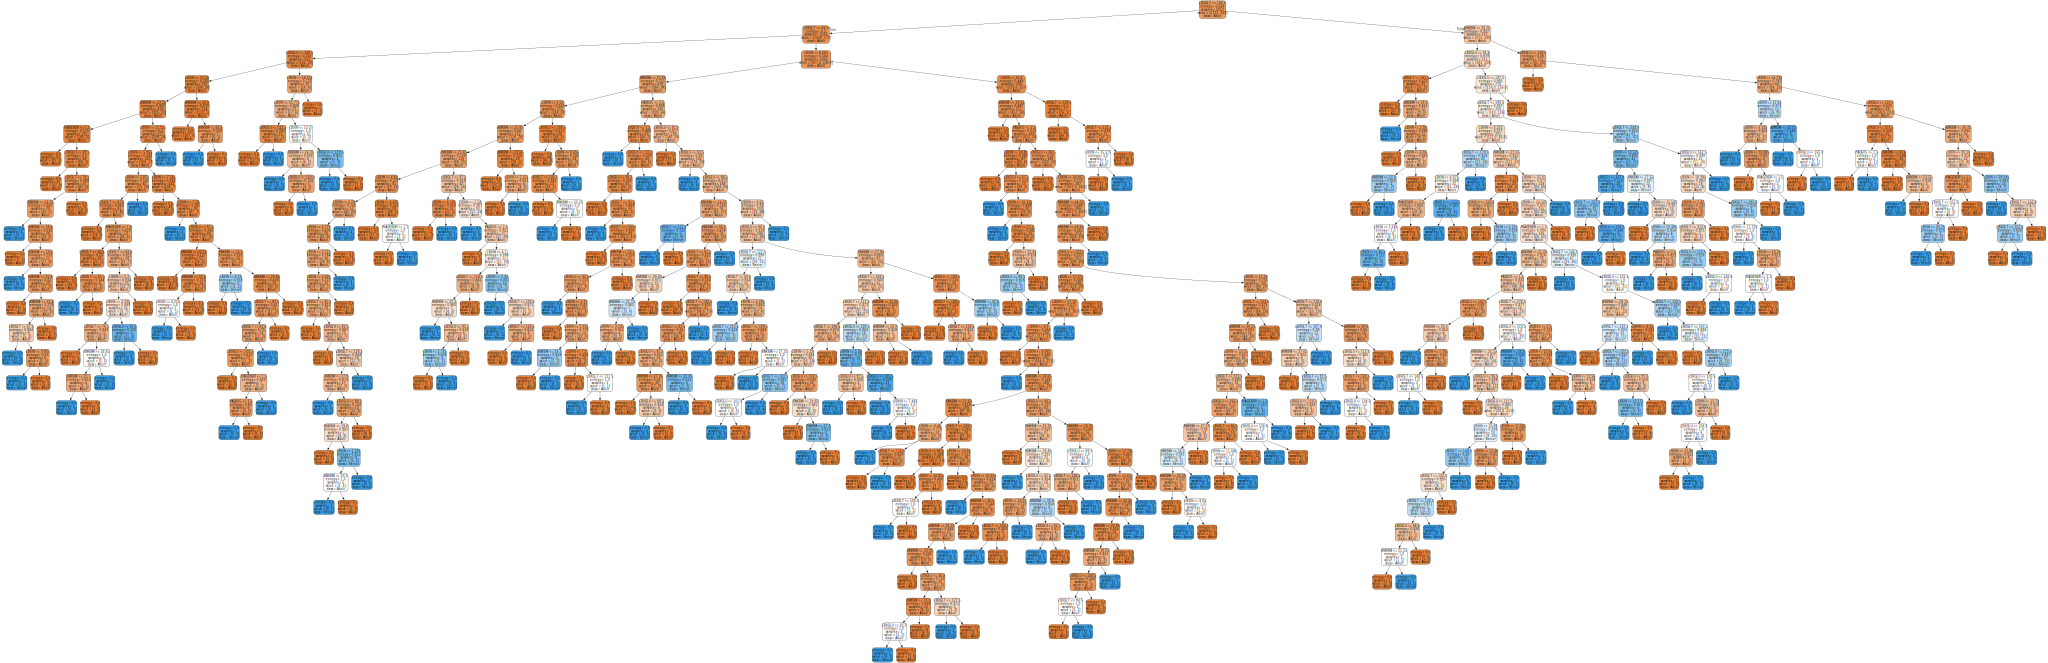

### 📋 Classification Report

              precision    recall  f1-score   support

       Adult       0.86      0.86      0.86       192
      Senior       0.28      0.28      0.28        36

    accuracy                           0.77       228
   macro avg       0.57      0.57      0.57       228
weighted avg       0.77      0.77      0.77       228

Accuracy: 0.77


### 📊 Confusion Matrix

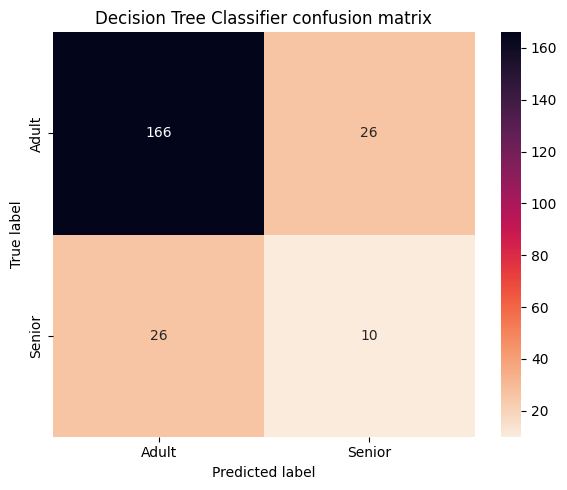

In [20]:
def evaluate_tree(feature_train, label_train, feature_test, label_test, max_depth=None):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(feature_train, label_train)
    predictions = dt.predict(feature_test)

    dot_data = export_graphviz(
        dt,
        out_file=None,
        feature_names=feature_train.columns,
        class_names=[str(x) for x in sorted(label_train.unique())],
        filled=True,
        rounded=True
    )
    display(graphviz.Source(dot_data))

    report = classification_report(label_test, predictions, target_names=sorted(label_train.unique()))
    acc = accuracy_score(label_test, predictions)
    cm = confusion_matrix(label_test, predictions, labels=sorted(label_train.unique()))
    
    display(Markdown(f"### 📋 Classification Report"))
    print(report)
    print(f"Accuracy: {acc:.2f}")

    display(Markdown(f"### 📊 Confusion Matrix"))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=sorted(label_train.unique()), yticklabels=sorted(label_train.unique()))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Decision Tree Classifier confusion matrix")
    plt.tight_layout()
    plt.show()

    return dt

display(Markdown(f"### 🌳 Decision Tree Visualization"))
for name, split in splits.items():
    print('-' * 50)
    display(Markdown(f"#### Splitting dataset with {name.replace('_', ' ')}"))
    evaluate_tree(
        split['feature_train'], 
        split['label_train'],
        split['feature_test'],
        split['label_test']
    )


### Mối liên hệ giữa chiều sâu và độ chính xác của mô hình
- Với việc thay đổi chiều sâu của mô hình Decision Tree, chúng ta sẽ thấy được mối liên hệ giữa chiều sâu và độ chính xác của mô hình.
- Mô hình chủ yếu tập trung và bộ dữ liệu với training set là 80% và test set là 20%.
- Thực nghiệm với các độ sâu lần lượt là không giới hạn, 2, 3, 4, 5, 6, 7.
- Với mỗi độ sâu, chúng ta sẽ xây dựng mô hình Decision Tree và đánh giá độ chính xác của mô hình trên tập kiểm tra.
- Cuối cùng, chúng ta sẽ trực quan hóa độ chính xác của mô hình với các độ sâu khác nhau thông qua bảng giá trị và biểu đồ, thực thi bằng matplotlib.pyplot.

### 🎨 Visualizing Decision Tree with each max_depth

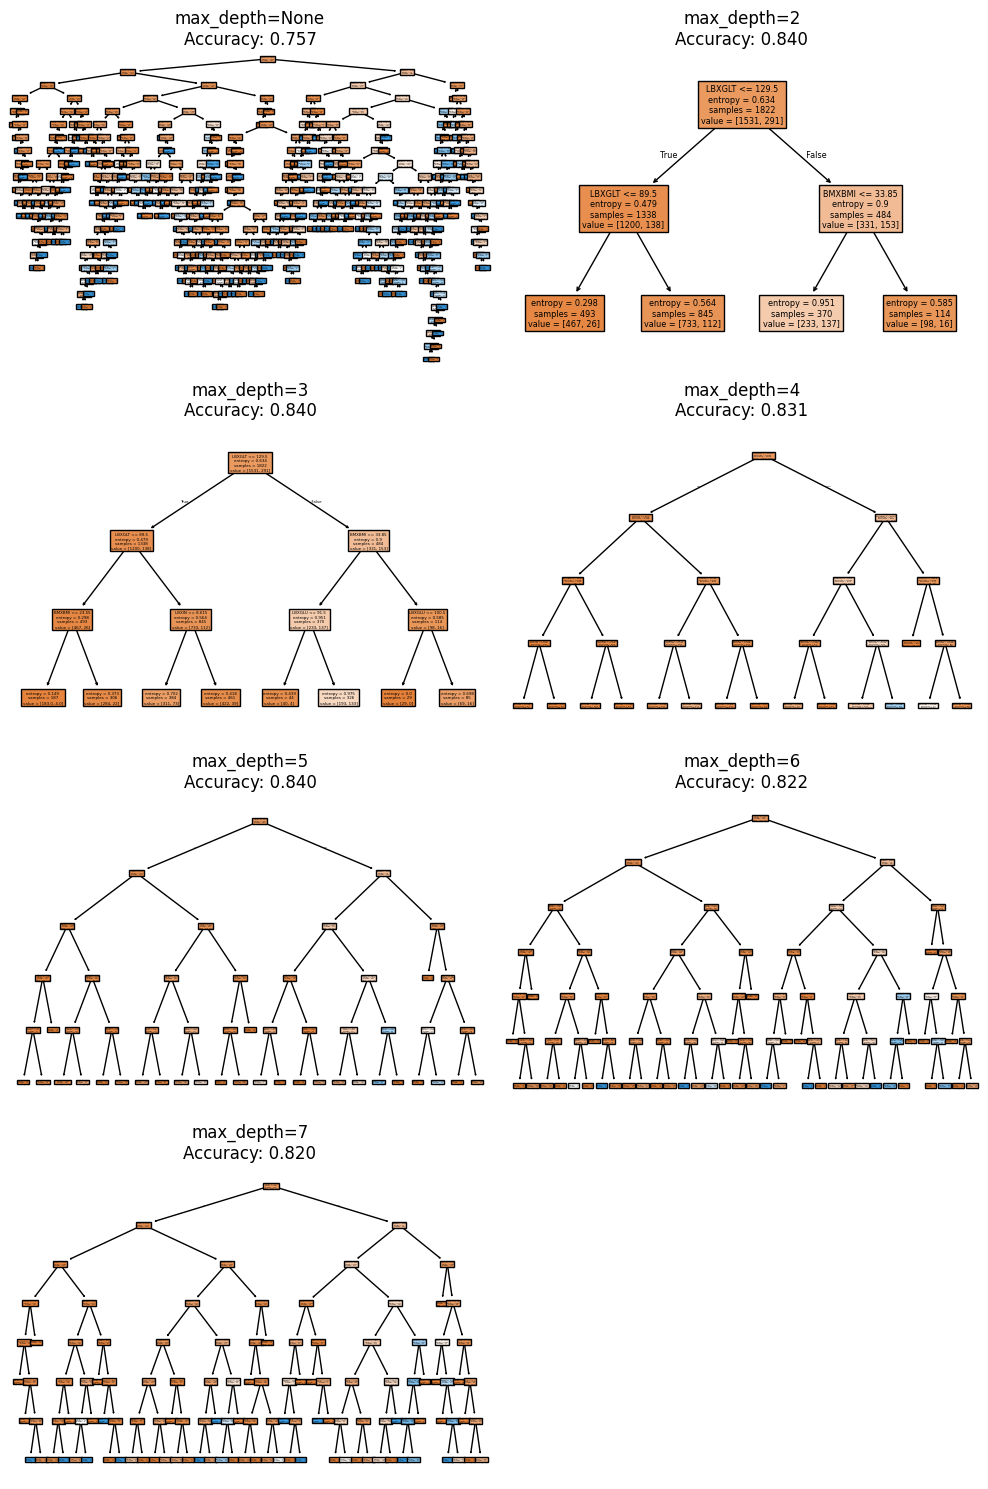

### 📊 Accuracy table for each max depth

╒══════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ max_depth=None   │ max_depth=2   │ max_depth=3   │ max_depth=4   │ max_depth=5   │ max_depth=6   │ max_depth=7   │
╞══════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 75.66%           │ 83.99%        │ 83.99%        │ 83.11%        │ 83.99%        │ 82.24%        │ 82.02%        │
╘══════════════════╧═══════════════╧═══════════════╧═══════════════╧═══════════════╧═══════════════╧═══════════════╛


### 📈 Accuracy vs max_depth chart

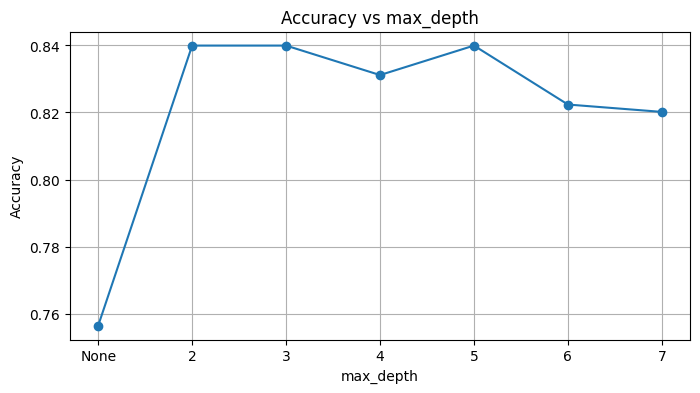

In [21]:
display(Markdown(f"### 🎨 Visualizing Decision Tree with each max_depth"))
X_train = splits['train_80_test_20']['feature_train']
y_train = splits['train_80_test_20']['label_train']
X_test = splits['train_80_test_20']['feature_test']
y_test = splits['train_80_test_20']['label_test']

max_depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

plt.figure(figsize=(10, 15))
for i, depth in enumerate(max_depths, 1):
    plt.subplot(4, 2, i)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    acc = dt.score(X_test, y_test)
    accuracies.append(acc)
    
    plot_tree(dt, feature_names=features.columns, filled=True)
    plt.title(f"max_depth={depth}\nAccuracy: {acc:.3f}")

plt.tight_layout()
plt.show()

headers = [f"max_depth={d}" for d in max_depths]
data = [[f"{acc:.2%}" for acc in accuracies]]

display(Markdown(f"### 📊 Accuracy table for each max depth"))
print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

display(Markdown(f"### 📈 Accuracy vs max_depth chart"))
plt.figure(figsize=(8, 4))
plt.plot([str(d) if d else 'None' for d in max_depths], accuracies, 'o-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth')
plt.grid(True)
plt.show()
